In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import cv2
from keras.utils import plot_model
from tqdm import tqdm_notebook
import time
import pickle

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

## Global variables

In [17]:
DIR_TFRECORDS = 'data_tfrecords'
DATA_TRAIN = sorted(glob('./'+DIR_TFRECORDS+'/train/*.tfrecords'), key=lambda s: s.lower())
DATA_EVAL = sorted(glob('./'+DIR_TFRECORDS+'/eval/*.tfrecords'), key=lambda s: s.lower())
DATA_TEST = sorted(glob('./'+DIR_TFRECORDS+'/test/*.tfrecords'), key=lambda s: s.lower())
IMG_H, IMG_W = 128, 128
NUM_CLASSES = 101

CLASSES = [os.path.splitext(f)[0] for f in sorted(os.listdir(DIR_TFRECORDS+'/train'), key=lambda s: s.lower())]

NUM_EPOCHS = 100
BATCH_SIZE = 16

DIR_CHECKPOINT = 'checkpoints_classification'
DIR_LOG = 'logs_classification'
INTERVAL_SUMMARY = 10
INTERVAL_LOG = 5

## Utility functions

In [4]:
# parses tfrecord file
def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'mask': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'idx_class': tf.FixedLenFeature(shape=(), dtype=tf.string)
    }

    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)

    # decode image
    img = tf.decode_raw(parsed['img'], tf.uint8)
    img = tf.cast(tf.reshape(img, [IMG_H, IMG_W, 3]), tf.float32)
    img /= 255.  # normalize

    # decode mask
    mask = tf.decode_raw(parsed['mask'], tf.uint8)
    mask = tf.cast(tf.reshape(mask, [IMG_H, IMG_W]), tf.float32)
    
    # decode label
    label = tf.decode_raw(parsed['idx_class'], tf.float32)
    label = tf.squeeze(label)

    return img, label, mask

## Model

In [5]:
class Classifier(tf.keras.Model):
    def __init__(self):
        super(Classifier, self).__init__()
        self.optimizer = tf.train.AdamOptimizer()
        
        # add layers
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D()

        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', use_bias=False)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.pool2 = tf.keras.layers.MaxPool2D()
        
        self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', use_bias=False)
        self.norm3 = tf.keras.layers.BatchNormalization()
        self.pool3 = tf.keras.layers.MaxPool2D()
        
        self.conv4 = tf.keras.layers.Conv2D(128, 1, padding='same', use_bias=False)
        self.norm4 = tf.keras.layers.BatchNormalization()
        self.pool4 = tf.keras.layers.MaxPool2D()
        
        self.conv5 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)
        self.norm5 = tf.keras.layers.BatchNormalization()
        self.pool5 = tf.keras.layers.MaxPool2D()
        
        self.conv6 = tf.keras.layers.Conv2D(NUM_CLASSES, 1, padding='same')
        self.avgpool6 = tf.keras.layers.AveragePooling2D(4)
        
    def forward(self, imgs):
        # imgs.shape = [B, IMG_H, IMG_W, 3]
        
        x = self.conv1(imgs)
        x = self.norm1(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.norm3(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool4(x)
        
        x = self.conv5(x)
        x = self.norm5(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool5(x)
        
        x = self.conv6(x)
        x = self.avgpool6(x)
        
        # reshape output
        pred = tf.reshape(x, [-1, NUM_CLASSES])
        
        return pred
    
    def get_loss(self, predictions, labels):
        loss = tf.losses.sparse_softmax_cross_entropy(labels, predictions)
        return loss
    
    def train(self, dataset, global_step):
        '''trains the model for one epoch'''
        
        accuracy = tfe.metrics.Accuracy()
        avg_loss = tfe.metrics.Mean('loss')
        time_start = time.time()
        
        for idx_batch, data in enumerate(dataset):
            with tf.contrib.summary.record_summaries_every_n_global_steps(
                INTERVAL_SUMMARY, global_step=global_step):
                with tfe.GradientTape() as tape:
                    # forward pass
                    predictions = self.forward(data[0])
                    idx_class = tf.argmax(predictions, axis=1, output_type=tf.int32)
                    
                    # compute loss
                    labels = tf.cast(data[1], tf.int32)
                    loss = self.get_loss(predictions, labels)
                    avg_loss(loss)
                    tf.contrib.summary.scalar('loss', loss)
                    
                    # compute accuracy
                    accuracy(idx_class, labels)
                    tf.contrib.summary.scalar('accuracy', accuracy.result())
                    
                # backward pass (compute gradients)
                gradients = tape.gradient(loss, self.variables)

                # update parameters
                self.optimizer.apply_gradients(zip(gradients, self.variables), global_step=global_step)
                
                # log
                if INTERVAL_LOG and idx_batch % INTERVAL_LOG == 0:
                    rate = INTERVAL_LOG / (time.time() - time_start)
                    print('Batch:{}\tLoss:{:.6f}\t{:.0f}steps/sec'.format(idx_batch, loss.numpy(), rate), end='\r')
                    time_start = time.time()
                    
        return avg_loss.result()
    
    def evaluate(self, dataset, flag_conf_matrix=False):
        '''Returns metrics on the dataset'''
        
        accuracy = tfe.metrics.Accuracy('accuracy')
        avg_loss = tfe.metrics.Mean('loss')
        
        idx_class_vec = []
        label_vec = []
        
        for data in dataset:
            # evaluate
            predictions = self.forward(data[0])
            idx_class = tf.argmax(predictions, axis=1, output_type=tf.int32)
            
            # compute loss
            labels = tf.cast(data[1], tf.int32)
            loss = self.get_loss(predictions, labels)
            avg_loss(loss)
            
            # compute accuracy
            accuracy(idx_class, labels)
            
            if flag_conf_matrix:
                # required for confusion matrix
                idx_class_vec.extend(idx_class)
                label_vec.extend(labels)
        
        print('Eval: loss={:.4f}, accuracy={:.4f}%\n'.format(avg_loss.result(), 100*accuracy.result()))
        
        with tf.contrib.summary.always_record_summaries():
            tf.contrib.summary.scalar('loss', avg_loss.result())
            tf.contrib.summary.scalar('accuracy', accuracy.result())
        
        if flag_conf_matrix:
            # convert to tensors
            idx_class_tensor = tf.stack(idx_class_vec)
            label_tensor = tf.stack(label_vec)
            
            # compute confusion matrix
            conf_matrix = tf.confusion_matrix(label_tensor, idx_class_tensor)
            
            return conf_matrix
    
    def predict(self, imgs):
        '''predicts bboxes and draws them on the image'''
        # imgs.shape = [B, IMG_H, IMG_W, 3]
        
        # forward pass
        predictions = self.forward(imgs)
        
        # find class
        idx_class = tf.argmax(predictions, 1, output_type=tf.int32)
        
        return idx_class
    
    def save_weights(self, dir_weights):
        '''saves layer weights in different files'''
        for idx_layer, layer in enumerate(self.layers):
            weights = layer.get_weights()
            filename = dir_weights + '/{}'.format(idx_layer)
            with open(filename, 'wb') as file:
                pickle.dump(weights, file)
        
        print('weights saved')

## Train

In [6]:
# training data
dataset_train = tf.data.TFRecordDataset(DATA_TRAIN)
dataset_train = dataset_train.map(parse_record)
dataset_train = dataset_train.shuffle(buffer_size=1024)
dataset_train = dataset_train.batch(BATCH_SIZE)

# evaluation data
dataset_eval = tf.data.TFRecordDataset(DATA_EVAL)
dataset_eval = dataset_eval.map(parse_record)
dataset_eval = dataset_eval.batch(BATCH_SIZE)

# test data
dataset_test = tf.data.TFRecordDataset(DATA_TEST)
dataset_test = dataset_test.map(parse_record)
dataset_test = dataset_test.batch(BATCH_SIZE)

In [7]:
# model
classifier = Classifier()

# log
writer_train = tf.contrib.summary.create_file_writer(DIR_LOG+'/train', flush_millis=10000, name='train')
writer_eval = tf.contrib.summary.create_file_writer(DIR_LOG+'/eval', flush_millis=10000, name='eval')
global_step = tf.train.get_or_create_global_step()

# checkpoint
checkpoint = tfe.Checkpoint(model=classifier, optimizer=classifier.optimizer, global_step=global_step)
checkpoint.restore(tf.train.latest_checkpoint(DIR_CHECKPOINT))

In [12]:
for epoch in tqdm_notebook(range(NUM_EPOCHS)):
    # train
    time_start = time.time()
    with writer_train.as_default():
        loss = classifier.train(dataset_train, global_step)
    time_end = time.time()
    print('\nTrain: epoch #{} ({} total steps): {:.0f} sec/epoch | loss:{}'.format(checkpoint.save_counter.numpy()+1, global_step.numpy(), time_end-time_start, loss.numpy()))
    
    # eval
    with writer_eval.as_default():
        classifier.evaluate(dataset_eval) 
    
    # save checkpoint
    checkpoint.save(file_prefix=os.path.join(DIR_CHECKPOINT, 'ckpt'))

HBox(children=(IntProgress(value=0), HTML(value='')))

Batch:365	Loss:0.207359	39steps/sec
Training time for epoch #41 (15170 total steps): 10 sec
Eval: loss=4.6031, accuracy=35.2475%

Batch:365	Loss:0.379822	38steps/sec
Training time for epoch #42 (15540 total steps): 10 sec
Eval: loss=5.0161, accuracy=36.2376%

Batch:365	Loss:0.332707	39steps/sec
Training time for epoch #43 (15910 total steps): 11 sec
Eval: loss=4.7675, accuracy=33.7624%

Batch:365	Loss:1.160680	38steps/sec
Training time for epoch #44 (16280 total steps): 10 sec
Eval: loss=5.2506, accuracy=35.7426%

Batch:365	Loss:0.199634	38steps/sec
Training time for epoch #45 (16650 total steps): 10 sec
Eval: loss=4.9545, accuracy=34.5545%

Batch:365	Loss:0.284485	38steps/sec
Training time for epoch #46 (17020 total steps): 10 sec
Eval: loss=4.9002, accuracy=35.6436%

Batch:365	Loss:0.273179	38steps/sec
Training time for epoch #47 (17390 total steps): 10 sec
Eval: loss=5.7487, accuracy=34.6535%

Batch:365	Loss:0.033968	39steps/sec
Training time for epoch #48 (17760 total steps): 10 se

Batch:365	Loss:0.000341	39steps/sec
Training time for epoch #104 (38480 total steps): 10 sec
Eval: loss=6.5932, accuracy=39.5050%

Batch:365	Loss:0.000781	39steps/sec
Training time for epoch #105 (38850 total steps): 10 sec
Eval: loss=7.5163, accuracy=39.4059%

Batch:365	Loss:0.098112	37steps/sec
Training time for epoch #106 (39220 total steps): 11 sec
Eval: loss=8.6115, accuracy=35.1485%

Batch:365	Loss:0.051773	37steps/sec
Training time for epoch #107 (39590 total steps): 10 sec
Eval: loss=7.0512, accuracy=36.4356%

Batch:365	Loss:0.002165	40steps/sec
Training time for epoch #108 (39960 total steps): 10 sec
Eval: loss=7.3610, accuracy=37.7228%

Batch:365	Loss:0.093884	38steps/sec
Training time for epoch #109 (40330 total steps): 10 sec
Eval: loss=6.5002, accuracy=37.7228%

Batch:365	Loss:0.000197	23steps/sec
Training time for epoch #110 (40700 total steps): 10 sec
Eval: loss=6.7915, accuracy=39.1089%

Batch:365	Loss:0.000287	38steps/sec
Training time for epoch #111 (41070 total steps

## Predict

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


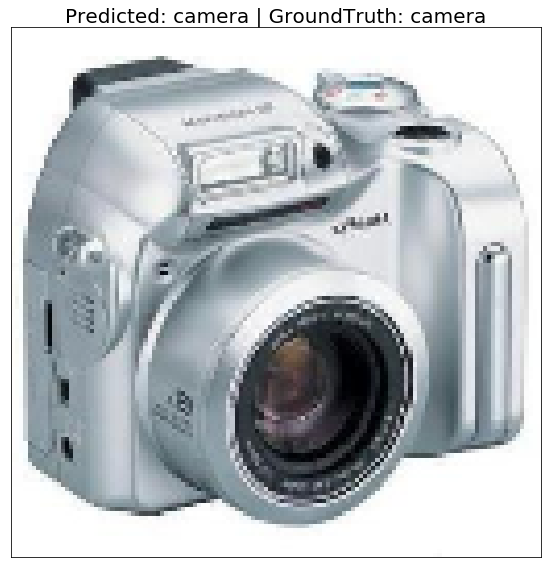

In [40]:
def process_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_W, IMG_H))
    img = (img / 255.).astype(np.float32)
    img = np.expand_dims(img, 0)
    
    return img

# read image
folder_name = 'camera'
idx = 18  # should be in range [11, 20]
img_path = '../test/input/{}/image_{:04}.jpg'.format(folder_name, idx)
img = cv2.imread(img_path)
img = process_img(img)

# load model
checkpoint.restore(tf.train.latest_checkpoint(DIR_CHECKPOINT))

# predict image
idx_class = classifier.predict(img)
class_pred = CLASSES[idx_class[0].numpy()]

# plot
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)

ax.imshow(img[0])
ax.set_title('Predicted: {} | GroundTruth: {}'.format(class_pred, folder_name), fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()
fig.show()
fig.savefig('{}.jpg'.format(folder_name))